In [127]:
import pandas as pd
import random
import numpy as np
import time
import math
import sys
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import datatable as dt

from xgboost import plot_tree
from os import walk
from os import listdir
from os.path import isfile, join
from scipy.spatial.distance import euclidean, pdist, squareform
from scipy.stats import skew
from scipy.special import expit as sigmoid
from scipy.cluster.hierarchy import fclusterdata
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import precision_recall_fscore_support
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [202]:
DATA_PATH = ''
#HISTORY_PATH = "Voter_History_{0}"
PREPROCESSED_PATH = "preprocessed/{0}/florida_processed_{0}.csv"
COUPLES_PATH="couples/{0}/couples_{0}.csv"
#COUPLES_PATH="couples/{0}/couples_FLA_{0}.csv"

In [203]:
import argparse

parser = argparse.ArgumentParser()

parser.add_argument('--old', dest='old_date', action='store', type=str, help='old date value')
parser.add_argument('--new', dest='new_date', action='store', type=str, help='new date value')

args = parser.parse_args()

usage: ipykernel_launcher.py [-h] [--old OLD_DATE] [--new NEW_DATE]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/rahullachh/.local/share/jupyter/runtime/kernel-e00808f8-be07-4534-bb04-288c132e4ea8.json


SystemExit: 2

In [204]:
#preprocessed_date = args.new_date
preprocessed_date = str(20190910)

In [205]:
#couples_date = args.old_date
couples_date = str(20180313)

In [206]:
image_file_prefix = couples_date + "_" + preprocessed_date
stat_file_prefix =  couples_date + "_" + preprocessed_date

import os
if not os.path.exists("plots/" + image_file_prefix):
    os.makedirs("plots/" + image_file_prefix)

if not os.path.exists("stats/" + stat_file_prefix):
    os.makedirs("stats/" + stat_file_prefix)
    
stat_file_path = "stats/" + stat_file_prefix + "/"

In [207]:
global_df = pd.read_csv(PREPROCESSED_PATH.format(preprocessed_date) , sep='\t')

/home/rahullachh/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [208]:
#global_df.residence_zipcode_5.unique().shape
zip_df = pd.read_csv("us-zipcode.csv" , sep=';')

In [209]:
#zip_df.head()

In [210]:
global_df.head()

,county_code,voter_id,last_name,first_name,residence_addr_line_1,residence_addr_line_2,residence_city,residence_zipcode,gender,race,birth_date,registration_date,party_affiliation,precinct,voter_status,age,residence_zipcode_5,residence_zipcode_4,uniq_addr
0,ALA,100419592,martin,william,3814 nw 266th st,NaN,newberry,32669,M,5,03/03/1972,03/19/1990,REP,6,ACT,47,32669,NaN,3814 nw 266th st newberry 32669
1,ALA,102146497,whitney,clinton,14116 se 202nd ter,NaN,hawthorne,32640,M,5,06/25/1981,03/08/2001,NPA,8,ACT,38,32640,NaN,14116 se 202nd ter hawthorne 32640
2,ALA,102183223,mulaiya,doodnauth,2296 nw 147th st,NaN,newberry,32669,M,2,06/01/1941,11/01/2001,DEM,49,ACT,78,32669,NaN,2296 nw 147th st newberry 32669
3,ALA,102097818,thalmann,michael,28524 n county road 1491,NaN,alachua,32615,M,5,11/26/1971,09/18/2000,REP,53,ACT,47,32615,NaN,28524 n county road 1491 alachua 32615
4,ALA,102078033,wack,angela,1214 nw 89th ter,NaN,gainesville,32606,F,5,05/04/1978,07/03/2000,DEM,56,ACT,41,32606,NaN,1214 nw 89th ter gainesville 32606


In [211]:
#zip_df_ = zip_df[['Zip','Latitude','Longitude','geopoint']]
#global_df = pd.merge(global_df, zip_df_, left_on=["residence_zipcode"], right_on=["Zip"])

In [212]:
req_cols = ['last_name', 'race', 'first_name']
global_df = global_df.dropna(subset=req_cols)

In [213]:
global_df.isnull().sum()

county_code                     0
voter_id                        0
last_name                       0
first_name                      0
residence_addr_line_1           0
residence_addr_line_2    11496956
residence_city                  0
residence_zipcode               0
gender                          0
race                            0
birth_date                      0
registration_date               0
party_affiliation               0
precinct                        0
voter_status                    0
age                             0
residence_zipcode_5             0
residence_zipcode_4      12037566
uniq_addr                       0
dtype: int64

In [214]:
global_df.shape

(14125318, 19)

In [215]:
# import pandas as pd
# import glob

# path = 'couples/20170307' # use your path
# all_files = glob.glob(path + "/*.csv")

# all_files.remove('couples/20170307/couples_POL_20170307.csv')
# li = []

# print(all_files)

# for filename in all_files:
#     print('Starting' + filename)
#     df = pd.read_csv(filename, sep = '\t' )
#     li.append(df)

In [216]:
# couples_df = pd.concat(li, axis=0, ignore_index=True)

In [217]:
# couples_df.head()

In [218]:
couples_df = pd.read_csv(COUPLES_PATH.format(couples_date) , sep='\t')

/home/rahullachh/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (13,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [219]:
couples_df.head()

,county_code_L,voter_id_L,last_name_L,first_name_L,residence_addr_line_1_L,residence_addr_line_2_L,residence_city_L,residence_zipcode_L,gender_L,race_L,...,race_R,birth_date_R,registration_date_R,party_affiliation_R,precinct_R,voter_status_R,age_R,residence_zipcode_5_R,residence_zipcode_4_R,age_diff
0,ALA,100401816,andrews,barbara,1440 se 24th pl,NaN,gainesville,326418708,F,3,...,3,07/28/1951,07/03/1982,DEM,28,ACT,66,32641,8708.0,0
1,ALA,100487261,degennaro,george,27 office pct,NaN,gainesville,32601,M,5,...,5,10/15/1977,09/13/2000,DEM,27,ACT,40,32601,NaN,0
2,ALA,100387876,frentzen,barbara,6812 nw 85th ter,NaN,gainesville,326532966,F,5,...,5,08/19/1945,10/19/1973,DEM,45,ACT,72,32653,2966.0,0
3,ALA,100393784,pring,bette,5519 sw 97th ter,NaN,gainesville,326084351,F,5,...,5,06/06/1942,07/22/1972,DEM,29,ACT,75,32608,4351.0,0
4,ALA,100394149,gaither,lourie,915 ne 25th ter,NaN,gainesville,32641,F,3,...,3,07/06/1939,08/25/1984,DEM,13,ACT,78,32641,NaN,0


In [220]:
couples_df[["uniq_addr"]].head()

,uniq_addr
0,1440 se 24th pl gainesville 32641
1,27 office pct gainesville 32601
2,6812 nw 85th ter gainesville 32653
3,5519 sw 97th ter gainesville 32608
4,915 ne 25th ter gainesville 32641


In [221]:
#addr_df = global_df[["voter_id","uniq_addr","Latitude","Longitude"]]
addr_df = global_df[["voter_id","uniq_addr"]]

## Collecting Addresses of voters

In [222]:
couples_df_found = pd.merge(couples_df, addr_df, left_on=["voter_id_L"], right_on=["voter_id"], suffixes=["","_L"])

In [223]:
del couples_df_found['voter_id']

In [224]:
couples_df_found = pd.merge(couples_df_found, addr_df, left_on=["voter_id_R"], right_on=["voter_id"], suffixes=["","_R"])

Merging Lat Long

In [225]:
couples_df_found.columns

Index(['county_code_L', 'voter_id_L', 'last_name_L', 'first_name_L',
       'residence_addr_line_1_L', 'residence_addr_line_2_L',
       'residence_city_L', 'residence_zipcode_L', 'gender_L', 'race_L',
       'birth_date_L', 'registration_date_L', 'party_affiliation_L',
       'precinct_L', 'voter_status_L', 'age_L', 'residence_zipcode_5_L',
       'residence_zipcode_4_L', 'uniq_addr', 'county_code_R', 'voter_id_R',
       'last_name_R', 'first_name_R', 'residence_addr_line_1_R',
       'residence_addr_line_2_R', 'residence_city_R', 'residence_zipcode_R',
       'gender_R', 'race_R', 'birth_date_R', 'registration_date_R',
       'party_affiliation_R', 'precinct_R', 'voter_status_R', 'age_R',
       'residence_zipcode_5_R', 'residence_zipcode_4_R', 'age_diff',
       'uniq_addr_L', 'voter_id', 'uniq_addr_R'],
      dtype='object')

### Removing extra column generated of voter id

In [226]:
del couples_df_found['voter_id']

In [227]:
couples_df_found[["voter_id_L","voter_id_R", "uniq_addr_L","uniq_addr_R"]].head()

,voter_id_L,voter_id_R,uniq_addr_L,uniq_addr_R
0,100401816,100402057,1440 se 24th pl gainesville 32641,1440 se 24th pl gainesville 32641
1,100487261,100505560,27 office pct gainesville 32601,27 office pct gainesville 32601
2,100387876,100387877,6812 nw 85th ter gainesville 32653,6812 nw 85th ter gainesville 32653
3,100393784,100393785,5519 sw 97th ter gainesville 32608,5519 sw 97th ter gainesville 32608
4,108652074,120124706,1114 nw 13th ave gainesville 32601,1114 nw 13th ave gainesville 32601


In [228]:
couples_df_found['separated'] = couples_df_found.apply(lambda x : x.uniq_addr_L != x.uniq_addr_R, axis=1)

## Separation percentage

In [229]:
couples_df_found['separated'].value_counts()

False    2670325
True      278064
Name: separated, dtype: int64

In [230]:
couples_df_found['separated'].value_counts()/couples_df_found['separated'].shape

False    0.90569
True     0.09431
Name: separated, dtype: float64

In [231]:
global_df['uniq_addr'].unique().shape

(7455943,)

In [232]:
couples_df_found.head()

,county_code_L,voter_id_L,last_name_L,first_name_L,residence_addr_line_1_L,residence_addr_line_2_L,residence_city_L,residence_zipcode_L,gender_L,race_L,...,party_affiliation_R,precinct_R,voter_status_R,age_R,residence_zipcode_5_R,residence_zipcode_4_R,age_diff,uniq_addr_L,uniq_addr_R,separated
0,ALA,100401816,andrews,barbara,1440 se 24th pl,NaN,gainesville,326418708,F,3,...,DEM,28,ACT,66,32641,8708.0,0,1440 se 24th pl gainesville 32641,1440 se 24th pl gainesville 32641,False
1,ALA,100487261,degennaro,george,27 office pct,NaN,gainesville,32601,M,5,...,DEM,27,ACT,40,32601,NaN,0,27 office pct gainesville 32601,27 office pct gainesville 32601,False
2,ALA,100387876,frentzen,barbara,6812 nw 85th ter,NaN,gainesville,326532966,F,5,...,DEM,45,ACT,72,32653,2966.0,0,6812 nw 85th ter gainesville 32653,6812 nw 85th ter gainesville 32653,False
3,ALA,100393784,pring,bette,5519 sw 97th ter,NaN,gainesville,326084351,F,5,...,DEM,29,ACT,75,32608,4351.0,0,5519 sw 97th ter gainesville 32608,5519 sw 97th ter gainesville 32608,False
4,ALA,108652074,neeld,dennis,1114 nw 13th ave,NaN,gainesville,32601,M,5,...,NPA,7,INA,33,32601,NaN,0,1114 nw 13th ave gainesville 32601,1114 nw 13th ave gainesville 32601,False


## Logging total separation percentage in file

In [233]:
total_separated_couples = couples_df_found[couples_df_found["separated"] == True].shape[0]
with open(stat_file_path + "total_separation_percentage.csv", "w") as f:
    f.write("\t".join(["separated_count", "total_count", "percentage"]) + "\n")
    f.write("\t".join([str(total_separated_couples), str(couples_df_found.shape[0]), str(100.0 * total_separated_couples/couples_df_found.shape[0])]))

## Convert race categorical 

In [234]:
race_codes = {
    1: "American Indian/Alaskan Native",
    2: "Asian/Pacific Islander",
    3: "Black/Not Hispanic",
    4: "Hispanic",
    5: "White",
    6: "Other",
    7: "Mutli-racial",
    9: "Unknown"
}

## Converting race codes to corresponding race-descriptions

In [235]:
def race_code_lambda(row, subscript):
    if pd.isnull(row["race_" + subscript]):
        return None
    code = int(row["race_" + subscript])
    return race_codes[code]

## Creating descriptive race columns is a time consuming process

In [236]:
couples_df_found["race_desc_L"] = couples_df_found.apply(lambda x: race_code_lambda(x, "L"), axis=1)
couples_df_found["race_desc_R"] = couples_df_found.apply(lambda x: race_code_lambda(x, "R"), axis=1)

In [237]:
global_df["race_desc"] = global_df["race"].apply(lambda x: race_codes[x])

## Feature wise separation percentage

In [238]:
cols = ["party_affiliation", "gender", "race_desc"]
unique_dic = {}
for c in cols:
    unique_dic[c] = set(global_df[c].unique())

## Demographic Percentages

In [239]:
party_affiliation_counts = {}
race_counts = {}

party_affiliation_percentages = {}
race_percentages = {}

total = global_df.shape[0]
for cat_value in unique_dic["party_affiliation"]:
    party_affiliation_counts[cat_value] = global_df[global_df["party_affiliation"] == cat_value].shape[0]
    party_affiliation_percentages[cat_value] = 100.0 * global_df[global_df["party_affiliation"] == cat_value].shape[0]/total

for cat_value in unique_dic["race_desc"]:
    race_counts[str(cat_value)] = global_df[global_df["race_desc"] == cat_value].shape[0]
    race_percentages[str(cat_value)] =  100.0 * global_df[global_df["race_desc"] == cat_value].shape[0]/total

## Thresholding Demographics
For Race we stick to 5% </br>
For Party affiliation we stick to 5%

In [240]:
race_percent_threshold = 5.0
race_other_groups = []
for cat_value in race_percentages:
    if race_percentages[cat_value] <= race_percent_threshold:
        race_other_groups.append(cat_value)

In [241]:
party_percent_threshold = 5.0
party_other_groups = []
for cat_value in party_affiliation_percentages:
    if party_affiliation_percentages[cat_value] <= party_percent_threshold:
        party_other_groups.append(cat_value)

# TODO

In [242]:
# TODO: Implement others mapping into global and couples dataframe
# def create_others_df()

In [243]:
global_df.shape

(14125318, 20)

In [244]:
print(str(unique_dic))

{'party_affiliation': {'NPA', 'GRE', 'CPF', 'IND', 'LPF', 'PSL', 'ECO', 'REF', 'DEM', 'REP'}, 'gender': {'F', 'M', 'U'}, 'race_desc': {'White', 'Hispanic', 'Mutli-racial', 'Unknown', 'Asian/Pacific Islander', 'American Indian/Alaskan Native', 'Other', 'Black/Not Hispanic'}}


## Generate Pair-wise stats by feature
Current focus is only on gender/race/political-affiliation

In [245]:
import time
from itertools import combinations 

def generate_category_based_on_pair_values(first_val, second_val):
    return "({0}, {1})".format(str(first_val), str(second_val))

def generate_pair_stats_by_feature(global_df, couples_df_found, feature, stats={}, others=[]):
    print("Collecting uniques by feature: " + feature)
    unique_vals = list(global_df[feature].unique())
    cat_combinations = list(combinations(list(unique_vals), 2))
    
    stats[feature] = {}
    print("Processing : " + feature + " : Total comb: " + str(len(cat_combinations)))
    i = 0
    start_time = time.time()
    stats[feature]["Other Categories"] = {'count': 0, 'total': 0}
    for comb in cat_combinations:
        first_val = comb[0]
        second_val = comb[1]
        
        left_right = couples_df_found[(couples_df_found[feature + "_L"] == first_val) & (couples_df_found[feature + "_R"] == second_val)]
        right_left = couples_df_found[(couples_df_found[feature + "_L"] == second_val) & (couples_df_found[feature + "_R"] == first_val)]
        
        count = left_right[left_right["separated"] == True].shape[0]
        count += right_left[right_left["separated"] == True].shape[0]
        
        stat = {}
        stat["count"] = count
        
        if count == 0:
            continue
        
        if first_val in others or second_val in others:
            stats[feature]["Other Categories"]["count"] += count
            stats[feature]["Other Categories"]["total"] += left_right.shape[0] + right_left.shape[0]
            continue
        
        stat["total"] = left_right.shape[0] + right_left.shape[0]
        stat["percent"] = count * 100.0/(left_right.shape[0] + right_left.shape[0])
        
        category = generate_category_based_on_pair_values(first_val, second_val)
        stats[feature][category] = stat
        
        i += 1
        
    print("Total value combinations process: " + str(i) + " Total time (secs): " + str(time.time() - start_time))
    
    print("Processing symmetric combinations: " + feature + " : Total comb: " + str(len(unique_vals)))
    for val in unique_vals:
        subset = couples_df_found[(couples_df_found[feature + "_L"] == val) & (couples_df_found[feature + "_R"] == val)]
        
        count = subset[subset["separated"] == True].shape[0]
        
        if val in others:
            stats[feature]["Other Categories"]["count"] += count
            stats[feature]["Other Categories"]["total"] += subset.shape[0]
            continue
        
        stat = {}
        stat["count"] = count
        
        if count == 0:
            continue
        
        stat["total"] = subset.shape[0]
        stat["percent"] = count * 100.0/(subset.shape[0])
        
        category = generate_category_based_on_pair_values(val, val)
        stats[feature][category] = stat
        
    if len(others) > 0 and stats[feature]["Other Categories"]["count"] > 0:
        stats[feature]["Other Categories"]["percent"] = 100.0 * stats[feature]["Other Categories"]["count"]/stats[feature]["Other Categories"]["total"]
    else:
        del stats[feature]["Other Categories"]
    
    print("Done with processing feature: " + feature)
    
    return stats

In [246]:
stat_file_path

'stats/20180313_20190910/'

In [247]:
def plot_pairwise_stat_by_feature(feature, stats, total_couples=1):
    feature_stats = stats[feature]
    
    figures, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
    
    percent_stats = []
    pair_combinations = []
    totals = []
    
    for pair_comb in feature_stats:
        percent_stats.append(feature_stats[pair_comb]["percent"])
        totals.append(feature_stats[pair_comb]["total"])
        pair_combinations.append(pair_comb)

    plot_df = pd.DataFrame({"percent": percent_stats, "category_combination": pair_combinations, "totals": totals})
    plot_df["category_combination_percentage"] = 100.0*plot_df["totals"]/total_couples
    
    sns.barplot(x="percent", y="category_combination", data=plot_df, ax=axes[0], palette=sns.color_palette("Set2"))
    
    axes[0].set(xlabel="Separation percentage")
    
    #     sns.barplot(x="category_combination_percentage", y="category_combination", palette=sns.color_palette("Set2"), data=plot_df, ax=axes[1])

    #   Pie chart
    labels = pair_combinations
    sizes = plot_df["category_combination_percentage"].tolist()
    axes[1].pie(sizes, labels=labels, autopct='%1.1f%%', colors=['teal', 'salmon', 'silver', 'lightblue', 'orchid', 'pink', 'lightgreen', 'wheat'])
    axes[1].axis('equal')
    axes[1].set(xlabel="Category percentage out of total couples")
    
    
    axes[0].spines['right'].set_visible(False)
    axes[0].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)
    axes[1].spines['top'].set_visible(False)
    
    #     axes[0].set_title(feature)
    #     axes[1].set_title(feature + " wise couple proportion")

    #     Writing stats into file
    stat_file_name = feature + "_totalCouples-" + str(total_couples) + ".csv"
    plot_df.to_csv(stat_file_path + stat_file_name, sep="\t")
        
    plt.savefig("plots/" + image_file_prefix + "/" + image_file_prefix +  "_pairwise_stat_" + feature)
    plt.tight_layout()

In [248]:
stats = generate_pair_stats_by_feature(global_df, couples_df_found, "race_desc", others=race_other_groups)

Processing : race_desc : Total comb: 28
Total value combinations process: 3 Total time (secs): 31.3663969039917
Processing symmetric combinations: race_desc : Total comb: 8
Done with processing feature: race_desc


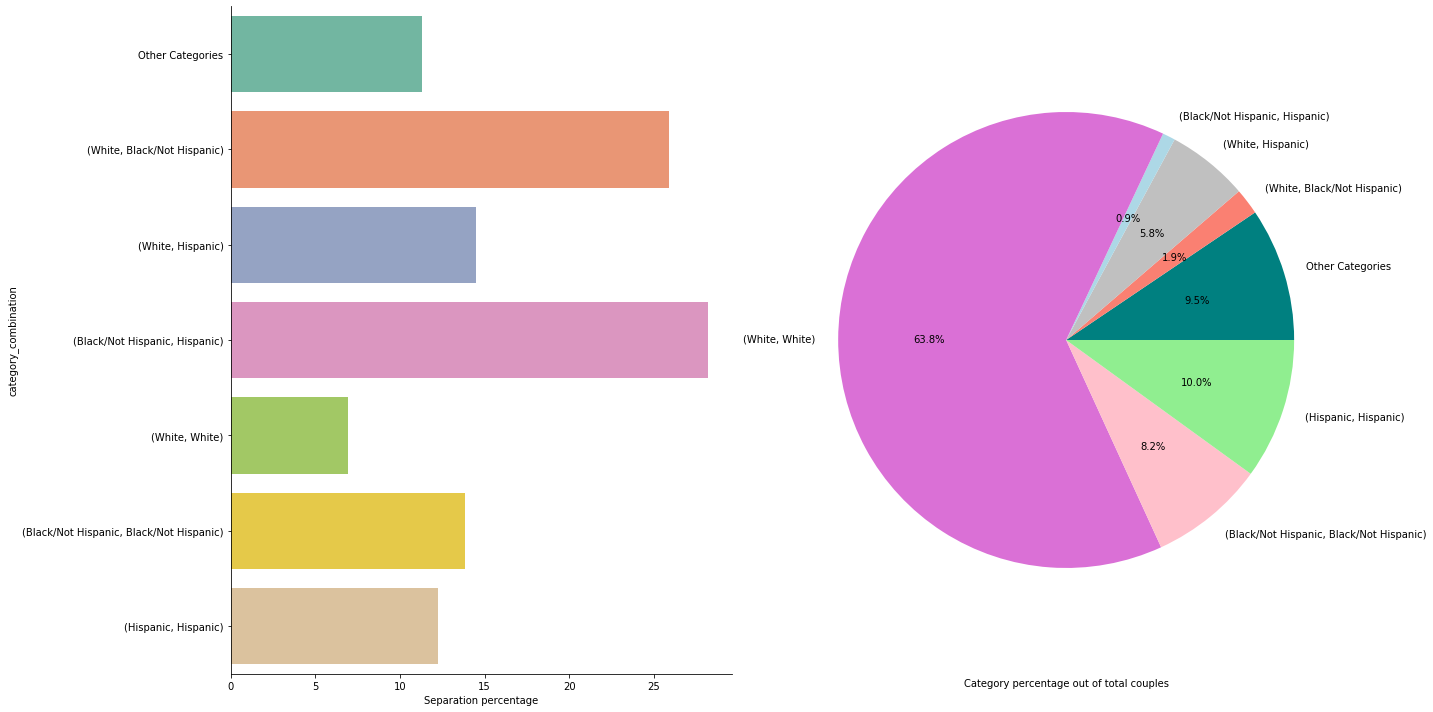

In [249]:
plot_pairwise_stat_by_feature("race_desc", stats, total_couples=couples_df_found.shape[0])

In [250]:
stats = generate_pair_stats_by_feature(global_df, couples_df_found, "party_affiliation", others=party_other_groups)

Processing : party_affiliation : Total comb: 45
Total value combinations process: 3 Total time (secs): 35.141794204711914
Processing symmetric combinations: party_affiliation : Total comb: 10
Done with processing feature: party_affiliation


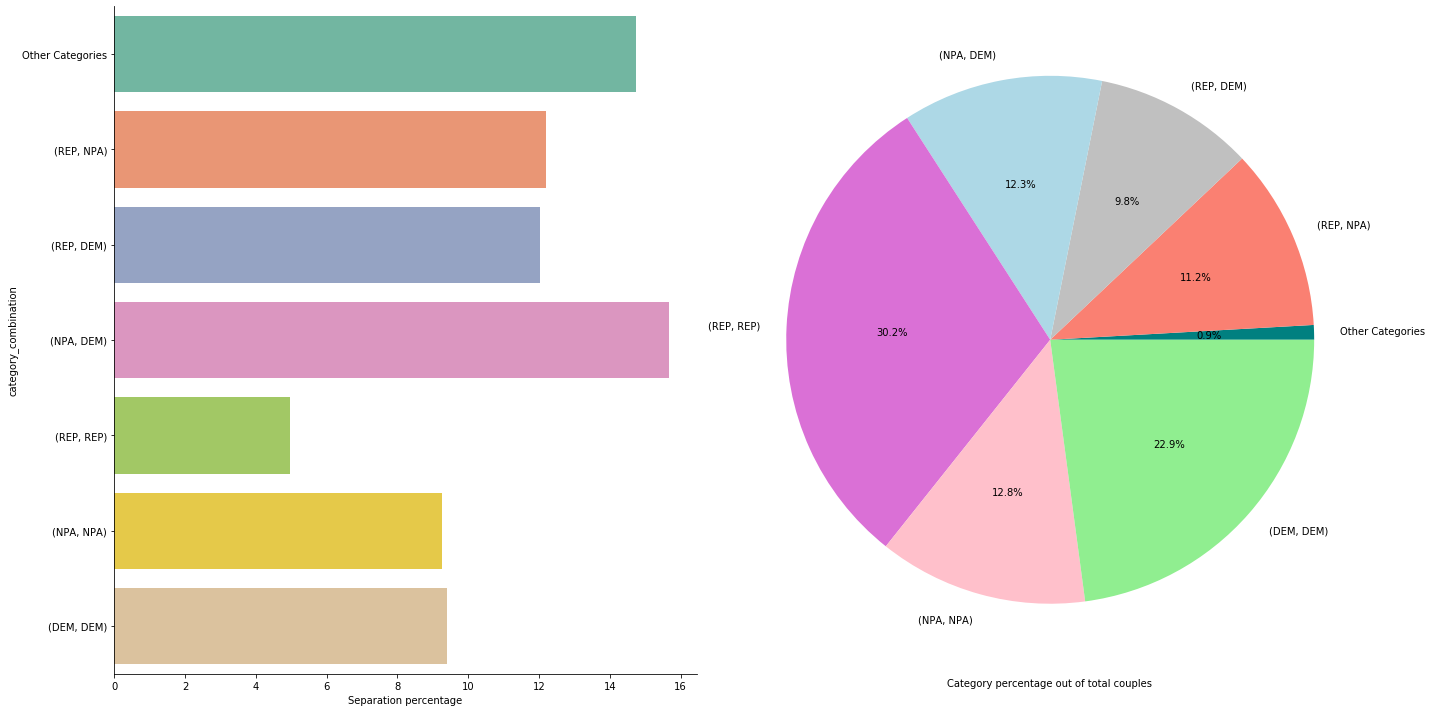

In [251]:
plot_pairwise_stat_by_feature("party_affiliation", stats, total_couples=couples_df_found.shape[0])

In [252]:
stats = generate_pair_stats_by_feature(global_df, couples_df_found, "gender", others=party_other_groups)

Processing : gender : Total comb: 3
Total value combinations process: 3 Total time (secs): 5.4475390911102295
Processing symmetric combinations: gender : Total comb: 3
Done with processing feature: gender


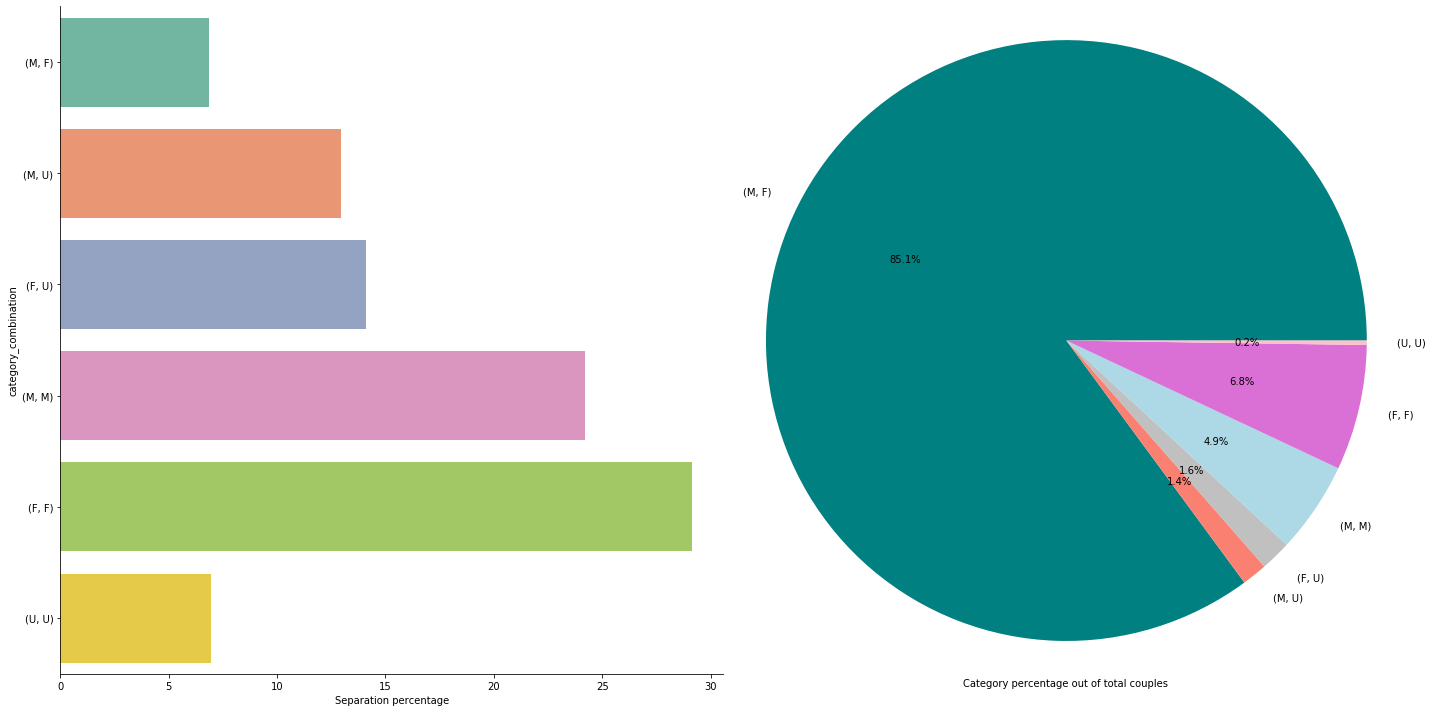

In [253]:
plot_pairwise_stat_by_feature("gender", stats, total_couples=couples_df_found.shape[0])

In [254]:
stats

{'race_desc': {'Other Categories': {'count': 31498,
   'total': 278711,
   'percent': 11.301312111829098},
  '(White, Black/Not Hispanic)': {'count': 14185,
   'total': 54852,
   'percent': 25.86049733829213},
  '(White, Hispanic)': {'count': 24740,
   'total': 170804,
   'percent': 14.48443830355261},
  '(Black/Not Hispanic, Hispanic)': {'count': 7537,
   'total': 26715,
   'percent': 28.2126146359723},
  '(White, White)': {'count': 130686,
   'total': 1881836,
   'percent': 6.944600911025191},
  '(Black/Not Hispanic, Black/Not Hispanic)': {'count': 33434,
   'total': 241099,
   'percent': 13.867332506563693},
  '(Hispanic, Hispanic)': {'count': 35984,
   'total': 294372,
   'percent': 12.22398869457693}},
 'party_affiliation': {'Other Categories': {'count': 3891,
   'total': 26401,
   'percent': 14.738078103102156},
  '(REP, NPA)': {'count': 40082,
   'total': 328750,
   'percent': 12.192243346007604},
  '(REP, DEM)': {'count': 34741,
   'total': 288938,
   'percent': 12.023686742484

## Raw code of combination stats (Obsolete)

In [255]:
# sns.barplot(x="percent_round", y="category", data=race_df)

In [256]:
couples_df_found.age_diff.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [257]:
age_diff_total_counts = couples_df_found.groupby(["age_diff"])["age_diff"].agg(["count"]).reset_index()

In [258]:
age_diff_total_counts.head()

,age_diff,count
0,0,355840
1,1,586068
2,2,461033
3,3,347221
4,4,264635


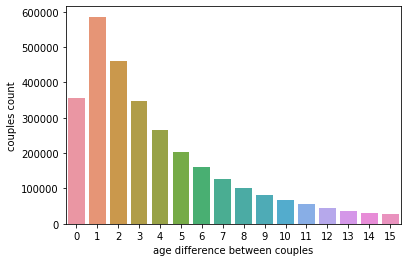

In [259]:
#plt.clear()
plt.close()
ax = sns.barplot(x="age_diff", y="count", data=age_diff_total_counts)
ax.set(xlabel='age difference between couples', ylabel='couples count')
plt.savefig("plots/" + image_file_prefix + "/" + image_file_prefix + "_age_diff_aggregation")

In [260]:
age_diff_separation_stats = couples_df_found[couples_df_found["separated"]==True].groupby(["age_diff"])["age_diff"].agg(["count"]).reset_index()

In [261]:
age_diff_separation_stats = pd.merge(age_diff_total_counts, age_diff_separation_stats, on=["age_diff"], suffixes=("_total", "_separated"))

In [262]:
age_diff_separation_stats["percent"] = 100.0 * age_diff_separation_stats["count_separated"]/age_diff_separation_stats["count_total"]

In [263]:
age_diff_separation_stats

,age_diff,count_total,count_separated,percent
0,0,355840,30754,8.642648
1,1,586068,49899,8.514200
2,2,461033,40286,8.738203
3,3,347221,29851,8.597118
4,4,264635,23324,8.813649
5,5,203481,18760,9.219534
6,6,159434,15586,9.775832
7,7,126283,12830,10.159721
8,8,100822,10844,10.755589
9,9,81945,9391,11.460126


In [264]:
age_diff_separation_stats.to_csv(stat_file_path + "age_diff_separation_stats.csv", sep='\t', header=["age_diff", "counts_of_that_age_diff", "separated_count", "separated_percentage"])

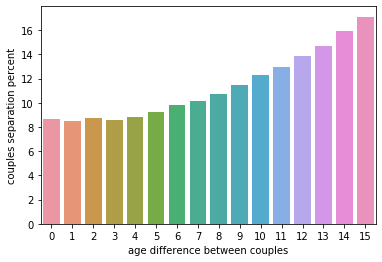

In [265]:
ax = sns.barplot(x="age_diff", y="percent", data=age_diff_separation_stats, )
ax.set(xlabel='age difference between couples', ylabel='couples separation percent')
plt.savefig("plots/" + image_file_prefix + "/" + image_file_prefix + "_age_diff_separation_percentages")

In [266]:
couples_df_found.dtypes

county_code_L               object
voter_id_L                   int64
last_name_L                 object
first_name_L                object
residence_addr_line_1_L     object
residence_addr_line_2_L     object
residence_city_L            object
residence_zipcode_L          int64
gender_L                    object
race_L                       int64
birth_date_L                object
registration_date_L         object
party_affiliation_L         object
precinct_L                  object
voter_status_L              object
age_L                        int64
residence_zipcode_5_L        int64
residence_zipcode_4_L      float64
uniq_addr                   object
county_code_R               object
voter_id_R                   int64
last_name_R                 object
first_name_R                object
residence_addr_line_1_R     object
residence_addr_line_2_R     object
residence_city_R            object
residence_zipcode_R          int64
gender_R                    object
race_R              

In [268]:
import scipy.stats as stats
pearson_corr, corr_pvalue = stats.pearsonr(age_diff_separation_stats['age_diff'], age_diff_separation_stats['percent'])
print('Correlation of Age Diff Vs separation rate: {} \nP_value: {}'.format(pearson_corr, corr_pvalue))

Correlation of Age Diff Vs separation rate: 0.9559325357743431 
P_value: 7.699727459389078e-09


In [ ]:
couples_df_found.dtypes

In [ ]:
couples_df_found.shape

In [ ]:
gender_numeric_mapping = {"M" : 0, "F": 1, "U": 2}

In [ ]:
couples_df_found['gender_L_N'] = couples_df_found["gender_L"].apply(lambda x: gender_numeric_mapping[x])
couples_df_found['gender_R_N'] = couples_df_found["gender_R"].apply(lambda x: gender_numeric_mapping[x])

In [ ]:
couples_df_found[["gender_L_N", "gender_L", "gender_R_N", "gender_R"]].head()

In [ ]:
#features = ['race_L', 'race_R', 'separated']
#features = ['Latitude', 'Latitude_R','Longitude','Longitude_R', 'separated']
# features = ['Latitude', 'Latitude_R','Longitude','Longitude_R', 'separated']
features = ['gender_L_N', 'gender_R_N', 'separated']


In [ ]:
df = couples_df_found[couples_df_found['county_code_L']=='BRO'][features]

In [ ]:
df['sep']=np.where(df["separated"] == True , 1, 0) 

In [ ]:
del df['separated']

In [ ]:
df.describe()

In [ ]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(df)
df['tsne-X'] = tsne_results[:,0]
df['tsne-Y'] = tsne_results[:,1]

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-X", y="tsne-Y",
    hue="sep",
    palette=sns.color_palette("hls", 2),
    data=df,
    legend="full",
    alpha=0.3
)
plt.savefig('plots/florida_2014-19_BRO_gender_tsne')

In [ ]:
# cf_polarized_all = np.where(((couples_df_found["party_affiliation_L"] == "DEM") & (couples_df_found["party_affiliation_R"] == "DEM"))
#                             | ((couples_df_found["party_affiliation_L"] == "REP") & (couples_df_found["party_affiliation_R"] == "REP"))
#                             | ((couples_df_found["party_affiliation_L"] == "NPA") & (couples_df_found["party_affiliation_R"] == "NPA"))
#                         , 0, 1) 

In [ ]:
#pearson_corr, corr_pvalue = stats.pearsonr(cf_polarized_all, cf_separated)
#print('Correlation of Polarized couples Vs their separation rate: {} \nP_value: {}'.format(pearson_corr, corr_pvalue))

In [ ]:
#couples_df_stat = pd.read_csv("stats/20160307_20180313/party_affiliation_totalCouples-2709111.csv" , sep='\t')

In [ ]:
#couples_df_stat.columns = ["no", "separation_percent","cat_comb","total","cat_comb_percent"]

In [ ]:
#couples_df_stat["no"]

In [ ]:
from sklearn.metrics import jaccard_score

In [ ]:
#couples_df_n = pd.merge(couples_df, fla_lat, left_on="uniq_addr", right_on = "uniq_addr_2",)

In [ ]:
#couples_df_n.isnull().sum()

In [ ]:
jaccard_similarity(tokenized_row_L, tokenized_row_R)

In [ ]:
def jaccard_similarity(query, document):
    intersection = set(query).intersection(set(document))
    union = set(query).union(set(document))
    return len(intersection)/len(union)

In [ ]:
tokenized_row_L = [d.split() for d in couples_df_found['uniq_addr_L']]
tokenized_row_R = [d.split() for d in couples_df_found['uniq_addr_R']]


In [ ]:
from scipy.stats import chi2_contingency
#print(chi2_contingency(pd.crosstab(cf_polarized_all, cf_separated)))

def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

#cramers_corrected_stat(pd.crosstab(cf_polarized_all, cf_separated))